***Authors: Laia Porcar Guillamón, Luis Marcos López Casines***

***Date: 12/01/2022***

***Objective: Classify the fashion_mnist dataset using different Machine Learning models.***




    

**We start by importing all libraries we'll be using.**

In [7]:
%%time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import pandas as pd
from scipy.stats import entropy
from urllib.request import urlopen


from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from xgboost import XGBClassifier


import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense #simple linear layer
from tensorflow.keras.utils import to_categorical # transformation for classification labels
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping



Wall time: 0 ns


**Now let's import and flatten the data (from 28x28 images to 784 elements vectors)**

In [8]:
def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784)
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

**Next we print the shape of the data and divide the training set into a training and a validation set. The validation set will be used to choose the best model. The test set will be used to obtain the final accuracy score of the chosen best model. We will use 20% of the data for the validation set, this is 12k samples out of 60k.**

In [9]:
X_train_val, y_train_val, X_test, y_test = load_fashion_mnist()
print(X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify = y_train_val)

(60000, 784) (60000,) (10000, 784) (10000,)


**Let's examine wether our data is balanced or not. To do so we check how many entries belong to each class.**

In [10]:

print(f"Size of X_train: {len(X_train)}","\nClass representation in the training set:")
for x in range(10):
    print(f"Class {x}:{np.sum(y_train == x)}")

print(f"\nSize of X_val: {len(X_val)}", "\nClass representation in the validation set:")  
for x in range(10):
    print(f"Class {x}:{np.sum(y_val == x)}")

print(f"\nSize of X_test: {len(X_test)}","\nClass representation in the test set:")
for x in range(10):
    print(f"Class {x}:{np.sum(y_test == x)}")
    

Size of X_train: 48000 
Class representation in the training set:
Class 0:4800
Class 1:4800
Class 2:4800
Class 3:4800
Class 4:4800
Class 5:4800
Class 6:4800
Class 7:4800
Class 8:4800
Class 9:4800

Size of X_val: 12000 
Class representation in the validation set:
Class 0:1200
Class 1:1200
Class 2:1200
Class 3:1200
Class 4:1200
Class 5:1200
Class 6:1200
Class 7:1200
Class 8:1200
Class 9:1200

Size of X_test: 10000 
Class representation in the test set:
Class 0:1000
Class 1:1000
Class 2:1000
Class 3:1000
Class 4:1000
Class 5:1000
Class 6:1000
Class 7:1000
Class 8:1000
Class 9:1000


#### Our data is well balanced since all classes have approximately the same number of entries. Next step would be to scale the data, since some of the models we'll be using are sensible to the scaling. We'll use a MinMax Scaler from the sklearn preprocessing package.

In [11]:
Scaler = MinMaxScaler()
X_train_sc = Scaler.fit_transform(X_train)
X_val_sc = Scaler.transform(X_val)
X_test_sc = Scaler.transform(X_test)


**The idea is to do a GridSearchCV for different algorithms. However the main problem we have here is the amount of time it takes to train each model, since we have 784 features, 48000 examples and we want to check different combinations of hyperparameters.**

**To tackle this problem we decided to do a GridSearchCV taking ~40% of the training examples and trying to decrease the number of features. With these modifications we would choose which parameters fit our model best and use therefore use them on a complete analysis to decide what model to keep finally.** 

**One of the paths we'll follow to decrease the impact of the big number of features is to reduce the dimensionality of the data through the use of Principal Component Analysis (PCA). To choose a number of dimensions that ease our process but at the same time keeps the essence of the data we plot the cumulative explained variance against the number of components. A dimension of 100 seems to be a compromise between both.**

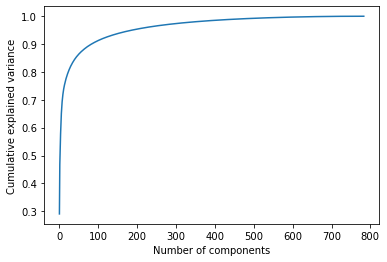

In [12]:
n_data = 20000 # number of data used to find the best parameters through GridSearchCV

pca = PCA().fit(X_train_sc)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig('pca_analysis.png')

pca = PCA(n_components= 100, random_state= 123)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
X_test_pca = pca.transform(X_test_sc)

**Our second path is to study by Univariate feature selection which features are more important and choose 392 (half of the total) of them to build our second data set for the GridSearchCV. This procedure works by selecting the best features based on univariate statistical tests, in our case chi2.**

In [13]:
sel = SelectKBest(chi2, k=392)
X_train_ufs = sel.fit_transform(X_train_sc, y_train)
X_val_ufs = sel.transform(X_val_sc)
X_test_ufs = sel.transform(X_test_sc)


 **We can try different algorithms:**

- *Decision Tree*
- *Random Forest*
- *SVM*
- *Ridge classifier*
- *Logistic regression*
- *KNN*
- *XGBoost*
- *NN*

**For each model we create a function that we'll call later, first with the lower dimension data (pca) and after with the data that keeps only half of the most important features (through the entropy analysis).** 

**Each function has a boolean parameter called 'choosing_param'. In case this is True the input data will go through a GridSearchCV to determine which are the best parameters for each model (based on the accuracy score output by the GridSearch).** 

**Comparing the accuracy of the model between the pca and the entropy data, we can extract the best model to proceed and train the whole data without dimensionality reduction or feature reduction. And that is done when 'choosing_param' = False.**


In [14]:
############### Decision Tree ###############

def decisiontree(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a Decision Tree algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''

    if choosing_param:
        dt_grid_params = {
            'criterion': ['entropy', 'gini'],
            'max_depth': (None,4,7,10),
            'min_samples_leaf' : (4,8,12)
            
        }

        dt_clf = DecisionTreeClassifier(random_state= 123)
        dt = GridSearchCV(dt_clf, dt_grid_params, n_jobs= -1, cv = 5)
        dt.fit(X_train, y_train)

        print(dt.best_params_)
        print(dt.best_score_)
        return dt.best_estimator_, dt.best_score_
    
    else:
        dt_clf = best_parameters
        dt_clf.fit(X_train, y_train)
        return dt_clf
        


In [15]:
############### Random Forest ###############

def randomforest(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a Random Forest algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''

    if choosing_param:
        rf_grid_params = {
            'n_estimators': (10, 100),
            'criterion': ['entropy'],
            'max_depth': (None, 5),
            'max_features' : ('sqrt','log2')
        }


        rf_clf = RandomForestClassifier(random_state= 123)
        rf = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
        rf.fit(X_train, y_train)

        print(rf.best_params_)
        print(rf.best_score_)
        return rf.best_estimator_ , rf.best_score_
    
    else:
        rf_clf = best_parameters
        rf_clf.fit(X_train, y_train)
        return rf_clf
        


In [16]:
############### SVM ###############

def suport_vector(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a Support Vector Machine algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''    

    if choosing_param:
        svc_grid_params = {
            'C': (10, 15, 20)
        }

        svc_clf = SVC(random_state= 123)
        svc = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)
        svc.fit(X_train, y_train)

        print(svc.best_params_)
        print(svc.best_score_)
        return svc.best_estimator_, svc.best_score_
    
    else:
        svc_clf = best_parameters
        svc_clf.fit(X_train, y_train)
        return svc_clf


In [17]:
############### Logistic regression ###############

def log_reg(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a Logistic Regression algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''
    
    if choosing_param:    
        lr_grid_params = { 
            'solver' : ['newton-cg', 'lbfgs', 'saga'],
            'C': (0.1,0.2, 0.4),
        }

        lr_clf = LogisticRegression(random_state= 123)
        lr = GridSearchCV(lr_clf, lr_grid_params, n_jobs = -1, cv = 5)
        lr.fit(X_train, y_train)

        print(lr.best_params_)
        print(lr.best_score_)
        return lr.best_estimator_, lr.best_score_
    
    else:
        lr_clf = best_parameters
        lr_clf.fit(X_train, y_train)
        return lr_clf

In [18]:
############### KNN ###############

def nearest_neighbors(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a KNN algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''

    if choosing_param:
        knn_grid_params = {
            'n_neighbors': (3,6,9,13),
            'metric': ['euclidean', 'manhattan','minkowski'],
            'weights' : ['uniform', 'distance']
            }


        knn_clf = KNeighborsClassifier()
        knn = GridSearchCV(knn_clf, knn_grid_params, n_jobs= -1, cv = 5)
        knn.fit(X_train, y_train)

        print(knn.best_params_)
        print(knn.best_score_)
        return knn.best_estimator_ , knn.best_score_
    
    else:
        knn_clf = best_parameters
        knn_clf.fit(X_train, y_train)
        return knn_clf


In [19]:
############### XGBoost ###############

def xgb(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a XGBoost algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''

    if choosing_param:
        xgb_grid_params = {
            'learning_rate': [0.03, 0.3]
            #'max_depth' : (3,7,15), 'n_estimators': (5,11)
            }

        xgb_clf = XGBClassifier(random_state= 123, use_label_encoder=False)
        xgb = GridSearchCV(xgb_clf, xgb_grid_params, n_jobs= -1, cv = 5)
        xgb.fit(X_train, y_train)

        print(xgb.best_params_)
        print(xgb.best_score_)
        return xgb.best_estimator_, xgb.best_score_
    
    else:      
        xgb_clf = best_parameters
        xgb_clf.fit(X_train, y_train)
        return xgb_clf


In [20]:
############### Ridge Classifier ###############

def ridge_classifier(X_train, y_train, choosing_param, best_parameters):
    ''' Implements a GridSearchCV for a Ridge Classifier algorithm when 'choosing_param' = True. 
        Returns the best estimator and best score found by the GridSearchCV.
        
        Fit a Ridge Classifier model with the given parameters ('best_parameters') when 'choosing_param' = False
        Returns the model.'''

    if choosing_param:
        rc_grid_params = {
            'alpha': (0.001,0.01,0.1)}
        
        rc_clf = RidgeClassifier(random_state= 123)
        rc = GridSearchCV(rc_clf, rc_grid_params, n_jobs= -1, cv = 5)
        rc.fit(X_train, y_train)
        
        print(rc.best_params_)
        print(rc.best_score_)
        return rc.best_estimator_, rc.best_score_
        
    else:
        rc_clf = best_parameters
        rc_clf.fit(X_train, y_train)
        return rc_clf


**As said before, we first call all algorithm functions with the pca data and store the information of best parameters and accuracy with those parameters in a list.**

In [21]:
%%time
best_pca_params = []

best_pca_dt = decisiontree(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_dt)
best_pca_rf = randomforest(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_rf)
best_pca_svc = suport_vector(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_svc)
best_pca_lr = log_reg(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_lr)
best_pca_knn = nearest_neighbors(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_knn)
best_pca_xgb = xgb(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_xgb)
best_pca_rc = ridge_classifier(X_train_pca[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_pca_params.append(best_pca_rc)


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 12}
0.7644
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
0.85605
{'C': 15}
0.8890500000000001
{'C': 0.4, 'solver': 'newton-cg'}
0.8477499999999999
{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
0.8544
[17:57:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.3}
0.869
{'alpha': 0.001}
0.8059499999999999
Wall time: 16min 55s


**Now we do the same with the data obtained from feature reduction.**

In [22]:
%%time
best_ufs_params = []

best_ufs_dt = decisiontree(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_dt)
best_ufs_rf = randomforest(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_rf)
best_ufs_svc = suport_vector(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_svc)
best_ufs_lr = log_reg(X_train_ufs[:n_data], y_train[:n_data],choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_lr)
best_ufs_knn = nearest_neighbors(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {} )
best_ufs_params.append(best_ufs_knn)
best_ufs_xgb = xgb(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_xgb)
best_ufs_rc = ridge_classifier(X_train_ufs[:n_data], y_train[:n_data], choosing_param = True, best_parameters = {})
best_ufs_params.append(best_ufs_rc)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8}
0.7844
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
0.85825
{'C': 10}
0.87895
{'C': 0.4, 'solver': 'newton-cg'}
0.83765
{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
0.8455999999999999
[18:20:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.3}
0.87935
{'alpha': 0.1}
0.7936
Wall time: 23min 7s


**Based on the accuracy score we can choose wether keeping the best parameters obtained with the pca data or the feature reduction data.**

In [23]:
best_params = []
for i in range(len(best_ufs_params)):
    if best_ufs_params[i][1] > best_pca_params[i][1]:
        best_params.append(best_ufs_params[i][0])
    else:
        best_params.append(best_pca_params[i][0])

**Now that we know the best hyperparameters to use, let's use them on the full data (all features and dimensions and all 60k samples), calling the algorithm functions with the 'choosing_param' = False.**

In [24]:
%%time

model_dt = decisiontree(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[0])
model_rf = randomforest(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[1])
model_svc = suport_vector(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[2])
model_lr = log_reg(X_train_sc, y_train,choosing_param = False, best_parameters = best_params[3])
model_knn = nearest_neighbors(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[4])
model_xgb = xgb(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[5])
model_rc = ridge_classifier(X_train_sc, y_train, choosing_param = False, best_parameters = best_params[6])

[18:25:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8min 16s


**Let's predict and find the accuracy for the training and validation sets, for each model.**

In [25]:
%%time
def choose_model(model,model_name, X_train,X_val,y_train,y_val):
    ''' Calculates the predictions of the training and validation sets and prints out the f1 and accuracy score of both.'''
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    print(f"{model_name} f1.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")
    print(f"{model_name} accuracy.\tTrain:{accuracy_score(y_train, y_train_pred):.4f}\tVal:{accuracy_score(y_val, y_val_pred):.4f}", end = "\n \n")

    
choose_model(model_dt,"Decision Tree", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_rf,"Random Forest", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_svc,"SVM", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_lr,"Logistic Regression", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_knn,"KNN", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_xgb,"XGB", X_train_sc, X_val_sc, y_train, y_val)
choose_model(model_rc,"Ridge Classifier", X_train_sc, X_val_sc, y_train, y_val)

Decision Tree f1.	Train:0.8459	Val:0.8127
Decision Tree accuracy.	Train:0.8461	Val:0.8135
 
Random Forest f1.	Train:1.0000	Val:0.8853
Random Forest accuracy.	Train:1.0000	Val:0.8867
 
SVM f1.	Train:0.9816	Val:0.8991
SVM accuracy.	Train:0.9816	Val:0.8995
 
Logistic Regression f1.	Train:0.8808	Val:0.8532
Logistic Regression accuracy.	Train:0.8815	Val:0.8538
 
KNN f1.	Train:1.0000	Val:0.8626
KNN accuracy.	Train:1.0000	Val:0.8631
 
XGB f1.	Train:1.0000	Val:0.9022
XGB accuracy.	Train:1.0000	Val:0.9027
 
Ridge Classifier f1.	Train:0.8295	Val:0.8175
Ridge Classifier accuracy.	Train:0.8329	Val:0.8203
 
Wall time: 46min 53s


**As we can see, the best model seems to be the SVM, since it yields the best accuracy for the validation set. However XGBoost follows very close behind.**

**But let's also try a neural network. For this we are going to try different layer configurations to determine which gives us the best accuracy.**

In [26]:
############### Neural Network ################################

# Build the function that will allow us to construct MLP with different layer numbers. Returns the model.

def MLP_definer(n_layers, input_size, n_classes):
    ''' Allows to construct MLP with the given layer number. 
        Returns the model.'''
    #seed
    np.random.seed(123)
    set_random_seed(2)
    
    #define a sequential model
    model = Sequential()

    if n_layers == 0:
        model.add(Dense(input_dim = input_size, units = input_size, activation= 'relu'))
    else:
        #define the first layer 
        for i in range(n_layers):
            if i == 0: #input layer
                model.add(Dense(input_dim = input_size, units = input_size, activation='relu'))
            else:
                model.add(Dense(units = 392, activation = 'relu'))

    model.add(Dense(units = n_classes, activation= 'softmax'))

    # Configure the model
    model.compile(loss='categorical_crossentropy', #loss metric
              optimizer='sgd',  #optimizer
              metrics=['accuracy']) #displayed metric

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00401: early stopping
N layers:0		Train ACC:0.88102084	Val ACC:0.87099999


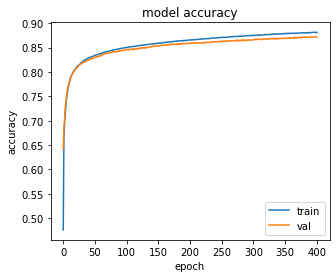

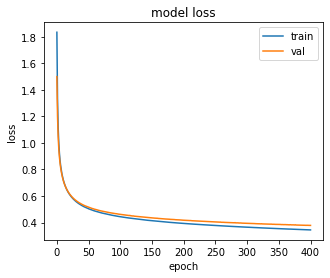






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00401: early stopping
N layers:1		Train ACC:0.88102084	Val ACC:0.87099999


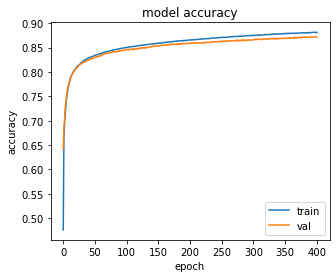

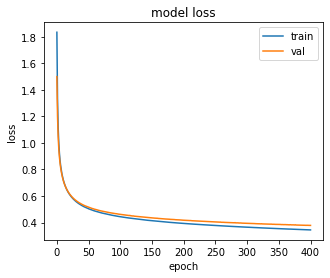






Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_5 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                3930      
Total params: 927,090
Trainable params: 927,090
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00101: early stopping
N layers:2		Train ACC:0.86139584	Val ACC:0.85416669


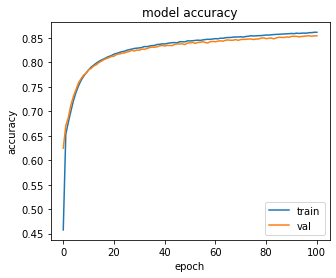

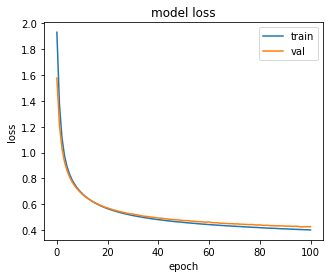






Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_9 (Dense)              (None, 392)               154056    
_________________________________________________________________
dense_10 (Dense)             (None, 392)               154056    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                3930      
Total params: 1,235,202
Trainable params: 1,235,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00044: early stopping
N layers:4		Train ACC:0.84574997	Val ACC:0.83733332


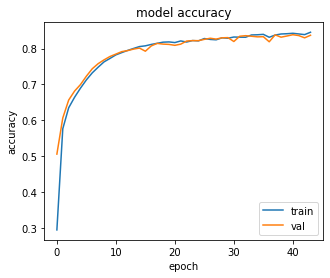

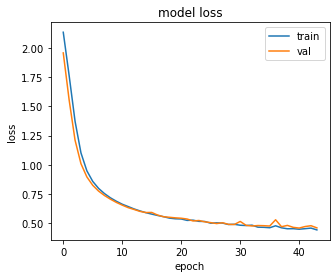






Wall time: 31min 24s


In [27]:
%%time

nlayers = [0, 1, 2, 4] # Number of layers we want to try out
my_input_size = len(X_train[0])
my_num_classes = 10
best_accuracy = 0
best_nn_model = 0


y_train_cat = to_categorical(y_train, my_num_classes)
y_val_cat = to_categorical(y_val, my_num_classes)


es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)


for nl in nlayers:
    #create the MLP
    m = MLP_definer(n_layers= nl, input_size =  my_input_size, n_classes= my_num_classes)
    print(m.summary())

    #train our model
    h = m.fit(X_train_sc, y_train_cat, validation_data = (X_val_sc,y_val_cat), epochs=500, 
                     batch_size=1200, verbose=0, callbacks=[es])
    
    print(f"N layers:{nl}\t\tTrain ACC:{h.history['accuracy'][-1]:.8f}\tVal ACC:{h.history['val_accuracy'][-1]:.8f}")
    
    
    # Summarize history for accuracy
    fig = plt.figure(figsize=(5,4))
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()


    # Summarize history for loss
    fig = plt.figure(figsize=(5,4))
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    ##### Keep model with highest accuracy #########
    
    if h.history['accuracy'][-1] > best_accuracy:
            best_accuracy = h.history['accuracy'][-1]
            best_nn_model = m
    
    print("\n\n\n\n")

In [28]:
# Calculate the accuracy and f1 scores on the validation set for the chosen neural network model:

y_train_pred = best_nn_model.predict_classes(X_train_sc)
y_val_pred = best_nn_model.predict_classes(X_val_sc)
print(f"Neural Network. f1\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")
print(f"Neural Network. Accuracy\tTrain:{accuracy_score(y_train, y_train_pred):.4f}\tVal:{accuracy_score(y_val, y_val_pred):.4f}")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Neural Network. f1	Train:0.8810	Val:0.8703
Neural Network. Accuracy	Train:0.8815	Val:0.8710


**As we can see the SVM accuracy score for the validation set is still higher than that if the neural network. Thus we choose the SVM as our best model and calculate the accuracy and f1 scores with the the test set (consisting on 10k samples).**

In [29]:
y_test_pred = model_svc.predict(X_test_sc)
print(f"SVC. f1\tTest:{accuracy_score(y_test, y_test_pred):.4f}")
print(f"SVC. Accuracy\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

SVC. f1	Test:0.8957
SVC. Accuracy	Test:0.8956


**Finally, in an attempt to make the classification more visual we will have a look at the confusion matrix of the model and a classification report.**

              precision    recall  f1-score   support

     Class 0       0.83      0.85      0.84      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.80      0.84      0.82      1000
     Class 3       0.90      0.89      0.89      1000
     Class 4       0.83      0.82      0.83      1000
     Class 5       0.97      0.97      0.97      1000
     Class 6       0.74      0.71      0.73      1000
     Class 7       0.95      0.96      0.95      1000
     Class 8       0.97      0.98      0.97      1000
     Class 9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



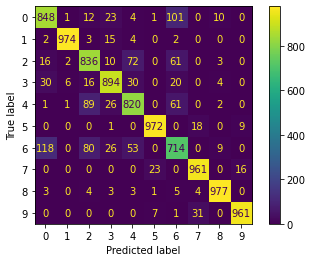

<Figure size 432x288 with 0 Axes>

In [30]:
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels = model_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svc.classes_)
disp.plot()
plt.show()
plt.savefig('confusion_matrix.png')